In [1]:
import numpy as np
import numpy.ma as ma
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
from matplotlib import gridspec
import itertools

In [44]:
DATA_DIR = "/scratch9/mkron/data/NN_out/run51/"
predictions_mctrue = pickle.load(file(os.path.join(DATA_DIR, 'prediction.pickle')))
epochs_acc_loss = np.delete(np.genfromtxt(os.path.join(DATA_DIR, "loss_logger.csv"), delimiter=','), 0, axis=0).T

In [45]:
classes = ("Cascade", "Track")
#classes = ("Down", "Up")

In [46]:
pred =  predictions_mctrue["prediction"]
mc_true = predictions_mctrue["mc_truth"]['classificationTag_truth'][:len(pred)]
reco_vals = predictions_mctrue["reco_vals"]
energy=[]
#for i in xrange(0, len(reco_vals)-1):
for i in xrange(0, len(pred)):
    energy.append(reco_vals[i][1])
energy = np.array(energy)

In [47]:
print energy
print reco_vals[1][1]

[   93.9153986     34.48370039   102.12494618 ...,   522.08587646
   207.80531311  6177.10326541]
34.4837003946


In [48]:
pred_for_Cascade = pred[mc_true == 1]
E_for_Cascade = energy[mc_true == 1]
pred_for_Track = pred[mc_true == 2]
E_for_Track = energy[mc_true == 2]

absolute, xe,ye = np.histogram2d(np.argmax(pred, axis=1)+1,mc_true,bins=(len(classes),len(classes)),range=((1,len(classes)),(1,len(classes))))
# that means that the prediction has to correspond to a event type 
res_true = absolute/np.sum(absolute,axis=0)
# normalization if the absolute values, so that the sum over PREDICTION is 1
# that means that a event hast to be predicted as one type 
res_pred = absolute/np.sum(absolute,axis=1).reshape(-1,1)

In [49]:
def plot_confusion_matrix(cm, classes,title="",
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(len(classes)), range(len(classes))):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=16)  

    plt.ylabel('Predicted label', fontsize=16)
    plt.xlabel('True label', fontsize=16)

In [50]:
def acc_vs_energy_plot(pred, true, energy, title, binnumber):
    '''
    inputs:
    pred: predictions of the NN of the events
    true: integer - what should the NN predict - number of class
    energy: energys of the events
       
    '''

    was_NN_right = [] #was_NN_right: Mask with 1 if prediction was right, if not 0
    for i in xrange(0,len(pred)):
        if np.argmax(pred[i])+1. == true:
            was_NN_right.append(1)
        else:
            was_NN_right.append(0)
    
    
    bins = np.linspace(np.min(np.log10(energy)), np.max(np.log10(energy)), binnumber)
    valsTrue = np.histogram(np.log10(energy), weights=was_NN_right, bins=bins)[0]
    valsAll = np.histogram(np.log10(energy), bins=bins)[0]
    acc = 1.*valsTrue/valsAll


    plt.plot(bins[:-1], acc, "x")
    #plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
    plt.xlabel('log_10(E) [GeV]', fontsize=16)

In [51]:
cutoff = 2*10**5
pred_low= pred[energy< cutoff]
pred_high= pred[energy> cutoff]
mc_true_low= mc_true[energy< cutoff]
mc_true_high= mc_true[energy> cutoff]

In [52]:
absolute_low, xe_low,ye_low = np.histogram2d(np.argmax(pred_low, axis=1)+1,mc_true_low,bins=(len(classes),len(classes)),range=((1,len(classes)),(1,len(classes))))
absolute_high, xe_high,ye_high = np.histogram2d(np.argmax(pred_high, axis=1)+1,mc_true_high,bins=(len(classes),len(classes)),range=((1,len(classes)),(1,len(classes))))
res_true_low = absolute_low/np.sum(absolute_low,axis=0)
res_true_high = absolute_high/np.sum(absolute_high,axis=0)
res_pred_low = absolute_low/np.sum(absolute_low,axis=1).reshape(-1,1)
res_pred_high = absolute_high/np.sum(absolute_high,axis=1).reshape(-1,1)


## Summary plot

/home/ga38tul/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide


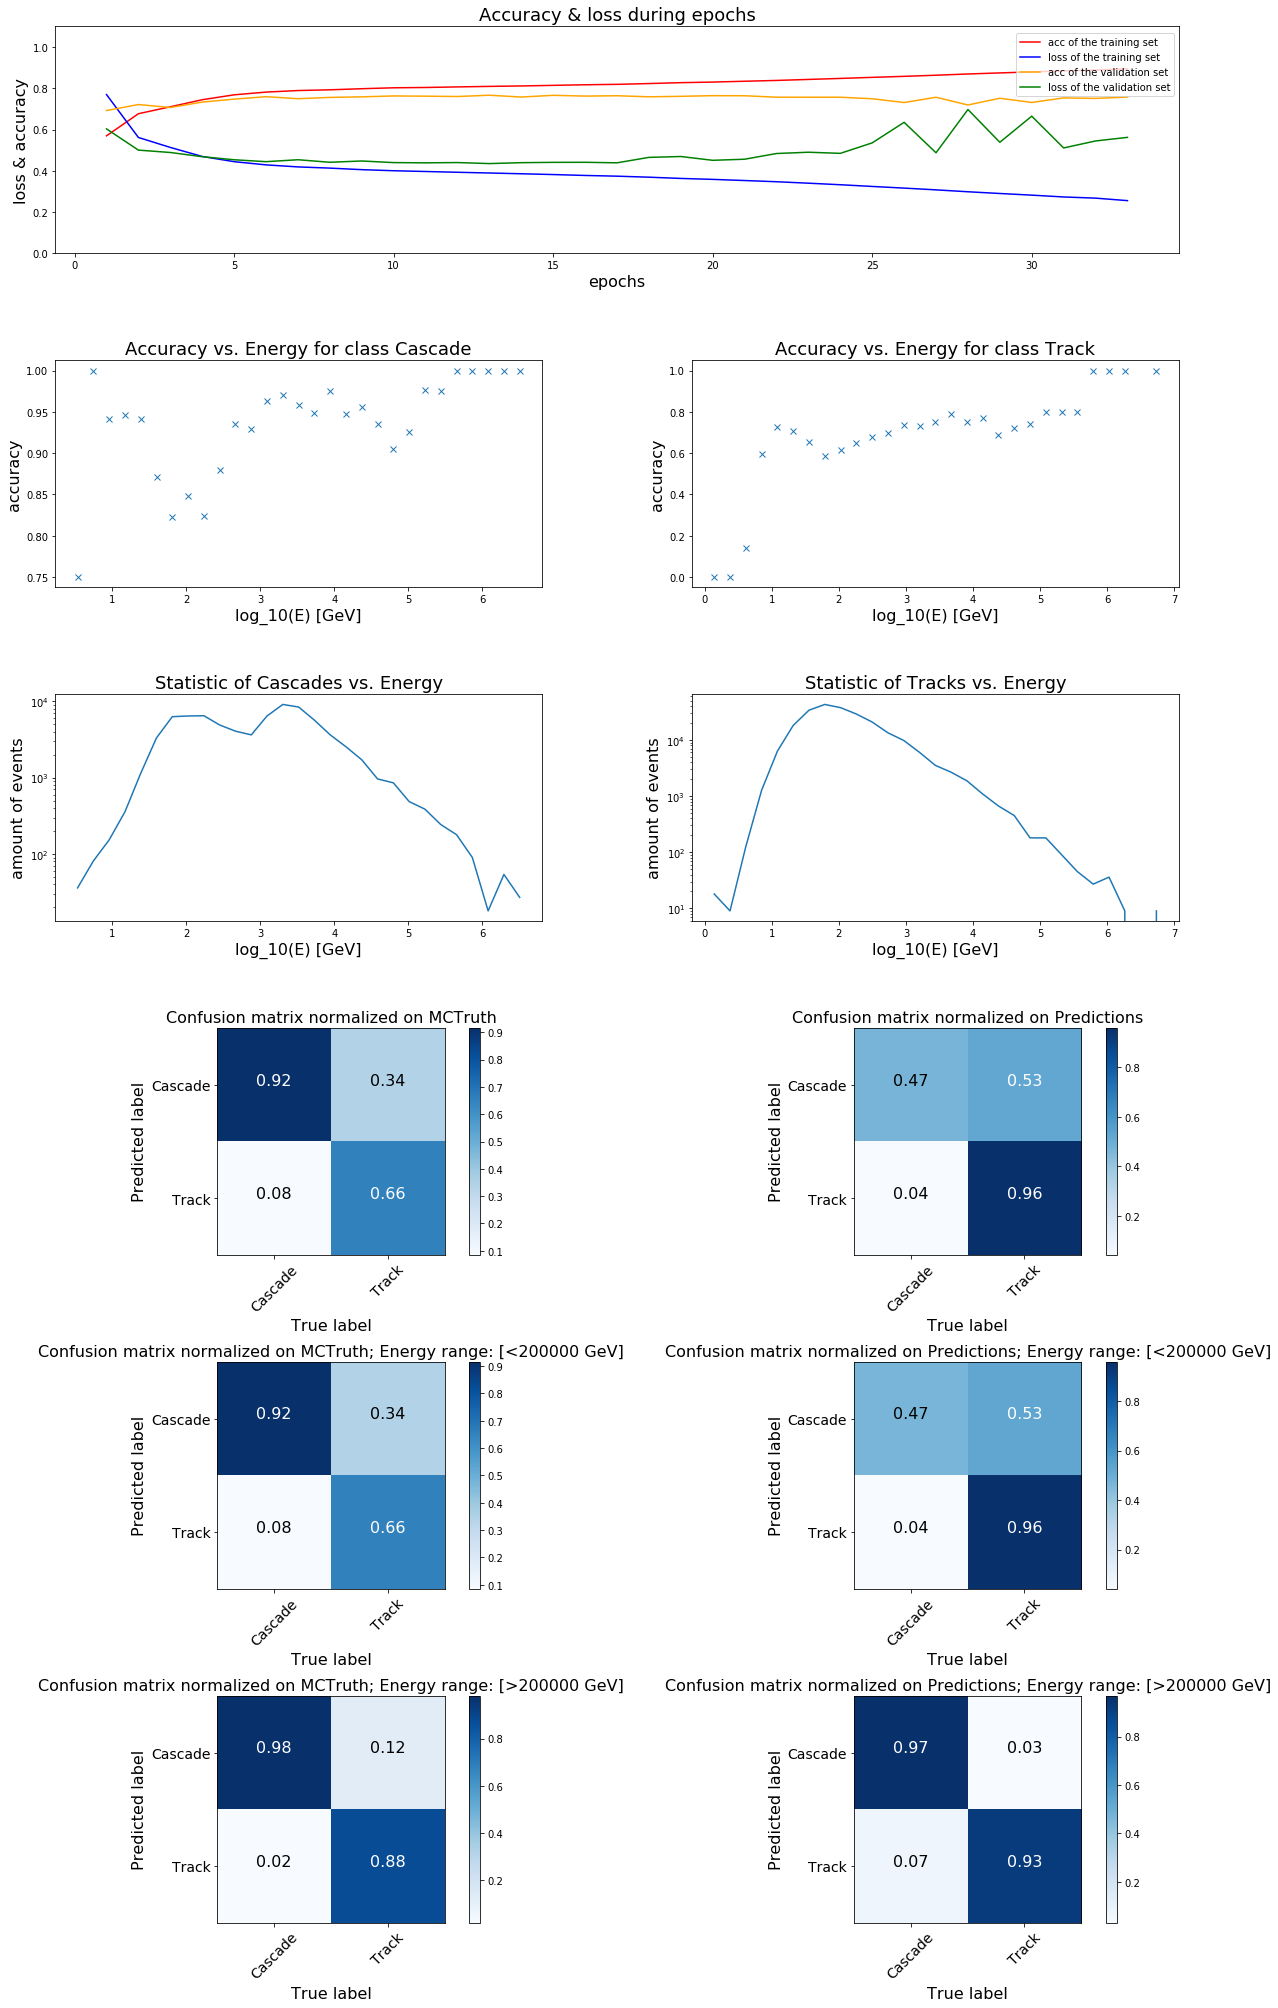

In [53]:
binnumber = 30
fig = plt.figure(figsize=(18,28))
ax1 = plt.subplot2grid((6, 2), (0, 0), colspan=2)
x = np.linspace(1, len(epochs_acc_loss[0]), num=len(epochs_acc_loss[0]), endpoint=True)
ax1.plot(x, epochs_acc_loss[1], color='red', label="acc of the training set")
ax1.plot(x, epochs_acc_loss[2], color='blue', label="loss of the training set")
ax1.plot(x, epochs_acc_loss[3], color='orange', label="acc of the validation set")
ax1.plot(x, epochs_acc_loss[4], color='green', label="loss of the validation set")
ax1.legend(bbox_to_anchor=(0.855, 0.97), loc=2, borderaxespad=0.)
ax1.set_title("Accuracy & loss during epochs", fontsize=18)
ax1.set_xlabel('epochs', fontsize=16)
ax1.set_ylabel('loss & accuracy', fontsize=16)
ax1.set_ylim(0., 1.1)

ax2 = plt.subplot2grid((6, 2), (1, 0))
ax2 = acc_vs_energy_plot(pred_for_Cascade, 1, E_for_Cascade, "Accuracy vs. Energy for class Cascade", binnumber)

ax3 = plt.subplot2grid((6, 2), (1, 1))
ax3 = acc_vs_energy_plot(pred_for_Track, 2, E_for_Track, "Accuracy vs. Energy for class Track", binnumber)

ax4 = plt.subplot2grid((6, 2), (2, 0))
bins = np.linspace(np.min(np.log10(E_for_Cascade)), np.max(np.log10(E_for_Cascade)), binnumber)
valsAll = np.histogram(np.log10(E_for_Cascade), bins=bins)[0]
ax4.semilogy(bins[:-1], valsAll)
ax4.set_title("Statistic of Cascades vs. Energy", fontsize=18)
ax4.set_xlabel('log_10(E) [GeV]', fontsize=16)
ax4.set_ylabel('amount of events', fontsize=16)

ax5 = plt.subplot2grid((6, 2), (2, 1))
bins = np.linspace(np.min(np.log10(E_for_Track)), np.max(np.log10(E_for_Track)), binnumber)
valsAll = np.histogram(np.log10(E_for_Track), bins=bins)[0]
ax5.semilogy(bins[:-1], valsAll)
ax5.set_title("Statistic of Tracks vs. Energy", fontsize=18)
ax5.set_xlabel('log_10(E) [GeV]', fontsize=16)
ax5.set_ylabel('amount of events', fontsize=16)


ax6 = plt.subplot2grid((6, 2), (3, 0))
plot_confusion_matrix(res_true, classes=classes, title='Confusion matrix normalized on MCTruth')

ax7 = plt.subplot2grid((6, 2), (3, 1))
plot_confusion_matrix(res_pred, classes=classes, title='Confusion matrix normalized on Predictions')

ax8 = plt.subplot2grid((6, 2), (4, 0))
plot_confusion_matrix(res_true_low, classes=classes, title='Confusion matrix normalized on MCTruth; Energy range: [<{} GeV]'.format(cutoff))

ax9 = plt.subplot2grid((6, 2), (4, 1))
plot_confusion_matrix(res_pred_low, classes=classes, title='Confusion matrix normalized on Predictions; Energy range: [<{} GeV]'.format(cutoff))

ax10 = plt.subplot2grid((6, 2), (5, 0))
plot_confusion_matrix(res_true_high, classes=classes, title='Confusion matrix normalized on MCTruth; Energy range: [>{} GeV]'.format(cutoff))

ax11 = plt.subplot2grid((6, 2), (5, 1))
plot_confusion_matrix(res_pred_high, classes=classes, title='Confusion matrix normalized on Predictions; Energy range: [>{} GeV]'.format(cutoff))

plt.tight_layout()
plt.show()

# save the above figure to the corresponding NN folder
fig.savefig(os.path.join(DATA_DIR, 'summary.pdf'))